In [1]:
#imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import warnings

#ignore warnings, something with lumi running on cpu instead of gpu (or rerversely)
warnings.filterwarnings('ignore')

#the main data file
FILE_SEQ = 'team_sequence_features.parquet'

#all the objectives/targets we wanna predict
TARGETS = [
    'dragon_taken_next_1min',
    'dragon_taken_next_2min',
    'dragon_taken_next_3min',
    'baron_taken_next_1min',
    'baron_taken_next_2min',
    'baron_taken_next_3min'
]

#load the data
print("loading data")
df_main = pd.read_parquet(FILE_SEQ)
print(f"done loading data, shape: {df_main.shape}")

#filter dataframe
print("filtering")
number_of_keeps = 30000
ids_to_keep = df_main['matchId'].unique()[:number_of_keeps]
df_main = df_main[df_main['matchId'].isin(ids_to_keep)]
print(f"filtered, new shape: {df_main.shape}")

#create enemy view and merge onto dataframe aka god view merge
print("god view merge")

#create copy for enemy team
df_enemy = df_main.copy()

#flip team ID in order to merge
df_enemy['join_team_id'] = df_enemy['teamId'].apply(lambda x: 200 if x == 100 else 100)

#renamy enemy coloumns + exclude keys used for joining the two dataframes
join_keys = ['matchId', 'minute', 'join_team_id']
rename_map = {col: f"enemy_{col}" for col in df_enemy.columns if col not in join_keys}
df_enemy = df_enemy.rename(columns=rename_map)

#actually merge
df_main = pd.merge(
    df_main, 
    df_enemy, 
    left_on=['matchId', 'minute', 'teamId'], 
    right_on=['matchId', 'minute', 'join_team_id'], 
    how='inner'
)

#clean up
del df_enemy
gc.collect()
print(f"god view merge done, shape: {df_main.shape}")
godview_aaby = 'godview_aaby.parquet'
df_main.to_parquet(godview_aaby, index=False)

loading data
done loading data, shape: (3435922, 1113)
filtering
filtered, new shape: (1643632, 1113)
god view merge
god view merge done, shape: (1643632, 2225)


In [5]:
#imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GroupKFold

#coloumns to exclude from training features
print("preparing features")

#these could leak future information to the model
leakage_cols = [
    'dragon_eligible_next_1min', 'dragon_eligible_next_2min', 'dragon_eligible_next_3min',
    'baron_eligible_next_1min', 'baron_eligible_next_2min', 'baron_eligible_next_3min'
]

#must drop enemy's future info too
enemy_leakage_cols = [f"enemy_{c}" for c in TARGETS + leakage_cols]
base_drops = ['matchId', 'teamId', 'join_team_id', 'enemy_teamId'] 

#targets obviously leak info, matchid and teamid isnt relevant (the teams have their own rows)
#combine drops
cols_to_drop = base_drops + TARGETS + leakage_cols + enemy_leakage_cols

#the base feature matrix
X = df_main.drop(columns=cols_to_drop, errors='ignore')

#convert false/true columns to 0/1
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

#free up memory
gc.collect()

#split for tuning and training (by match id)
train_ids_full, test_ids = train_test_split(df_main['matchId'].unique(), test_size=0.1, random_state=42)
train_ids, val_ids = train_test_split(train_ids_full, test_size=0.111, random_state=42)


###TRAINING

print(f"starting training for all 6 objectives")

results = {}


#masks
is_train = df_main['matchId'].isin(train_ids)
is_val = df_main['matchId'].isin(val_ids)
is_test = df_main['matchId'].isin(test_ids)

#pre-split
X_train_sub = X[is_train]
X_val = X[is_val] 
X_test_full = X[is_test]

for target in TARGETS:
    print(f"\n preparing training for: {target}")

    y_train_sub = df_main.loc[is_train, target]
    y_val = df_main.loc[is_val, target]
    y_test = df_main.loc[is_test, target]

    # dragon_taken_next_1min -> dragon_eligible_next_1min
    elig_col = target.replace('taken', 'eligible')
    

    #if 1, keep normal weight - jf 0 weight is 0 (masked).
    w_train_sub = df_main.loc[is_train, elig_col].astype(int).values
    w_val = df_main.loc[is_val, elig_col].astype(int).values
    
    print(f"masking {len(w_train_sub) - w_train_sub.sum()} samples")

    #scal_pos_weight on eligble samples only
    valid_y_train = y_train_sub[w_train_sub == 1]
    pos_count = sum(valid_y_train)
    neg_count = len(valid_y_train) - pos_count
    
    #only chuck norris can do division by zero
    pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
    print(f"eligible Positives: {pos_count}/{len(valid_y_train)} (weight: {pos_weight:.2f})")




    print(f"tuning hyperparams for {target}")
    
    sample_matches = np.random.choice(train_ids, 10000, replace=False)
    mask_sample = df_main['matchId'].isin(sample_matches)
    
    #features and targets
    X_tune = X[mask_sample]
    y_tune = df_main.loc[mask_sample, target]
    #groups for groupkfold
    groups_tune = df_main.loc[mask_sample, 'matchId']
    
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 8, 10, 12],
        'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.13],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0]
    }

    xgb_tune = xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        scale_pos_weight=pos_weight,
        device="cpu", 
        tree_method="hist", 
        random_state=42
    )
    
    search = RandomizedSearchCV(
        estimator=xgb_tune,
        param_distributions=param_dist,
        n_iter=10, 
        scoring='average_precision', 
        cv=GroupKFold(n_splits=3),
        random_state=42,
        n_jobs=1
    )
    search.fit(X_tune, y_tune, groups=groups_tune)
    best_params = search.best_params_
    print(f"best params found: {best_params}")


    del search, X_tune, y_tune, groups_tune, xgb_tune
    gc.collect()
    
    print(f"training with early stopping...")
    


    #model with best params
    model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        scale_pos_weight=pos_weight,
        eval_metric='logloss',
        device="cuda", 
        tree_method="hist",
        random_state=42,
        early_stopping_rounds=20
    )

    # 4. Fit with weights (mask) and eval set
    model.fit(
        X_train_sub, y_train_sub,
        sample_weight=w_train_sub,        #los mask
        eval_set=[(X_val, y_val)],      #validation for early stoppin
        sample_weight_eval_set=[w_val], #loss mask for validation
        verbose=False
    )
    
    print(f"training success, best iteration: {model.best_iteration}")

    #save model
    model_filename = f"model_{target}.json"
    model.save_model(model_filename)
    print(f"model saved to {model_filename}")

    #test
    y_pred_proba = model.predict_proba(X_test_full)[:, 1]
    y_pred = model.predict(X_test_full) #>0.5 treshold for yes
    
    #performance metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    results[target] = {
        'ROC': roc_auc, 
        'PR': pr_auc, #more interested in this than roc_auc
        'Precision': precision, 
        'Recall': recall
    }

#final summary

print("summary:")
print(f"{'Target':<25} | {'PR AUC':<8} | {'Precision':<9} | {'Recall':<8}")

for t, scores in results.items():
    print(f"{t:<25} | {scores['PR']:.4f}   | {scores['Precision']:.4f}    | {scores['Recall']:.4f}")

preparing features
starting training for all 6 objectives

 preparing training for: dragon_taken_next_1min
masking 804900 samples
eligible Positives: 79355/510374 (weight: 5.43)
tuning hyperparams for dragon_taken_next_1min
best params found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
training with early stopping...
training success, best iteration: 499
model saved to model_dragon_taken_next_1min.json

 preparing training for: dragon_taken_next_2min
masking 618770 samples
eligible Positives: 159585/696504 (weight: 3.36)
tuning hyperparams for dragon_taken_next_2min
best params found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
training with early stopping...
training success, best iteration: 499
model saved to model_dragon_taken_next_2min.json

 preparing training for: dragon_taken_next_3min
masking 424622 samples
eligible Positives: 239815/890652 (weight: 2.71)
tu


visualizing game: LA1_1660404708


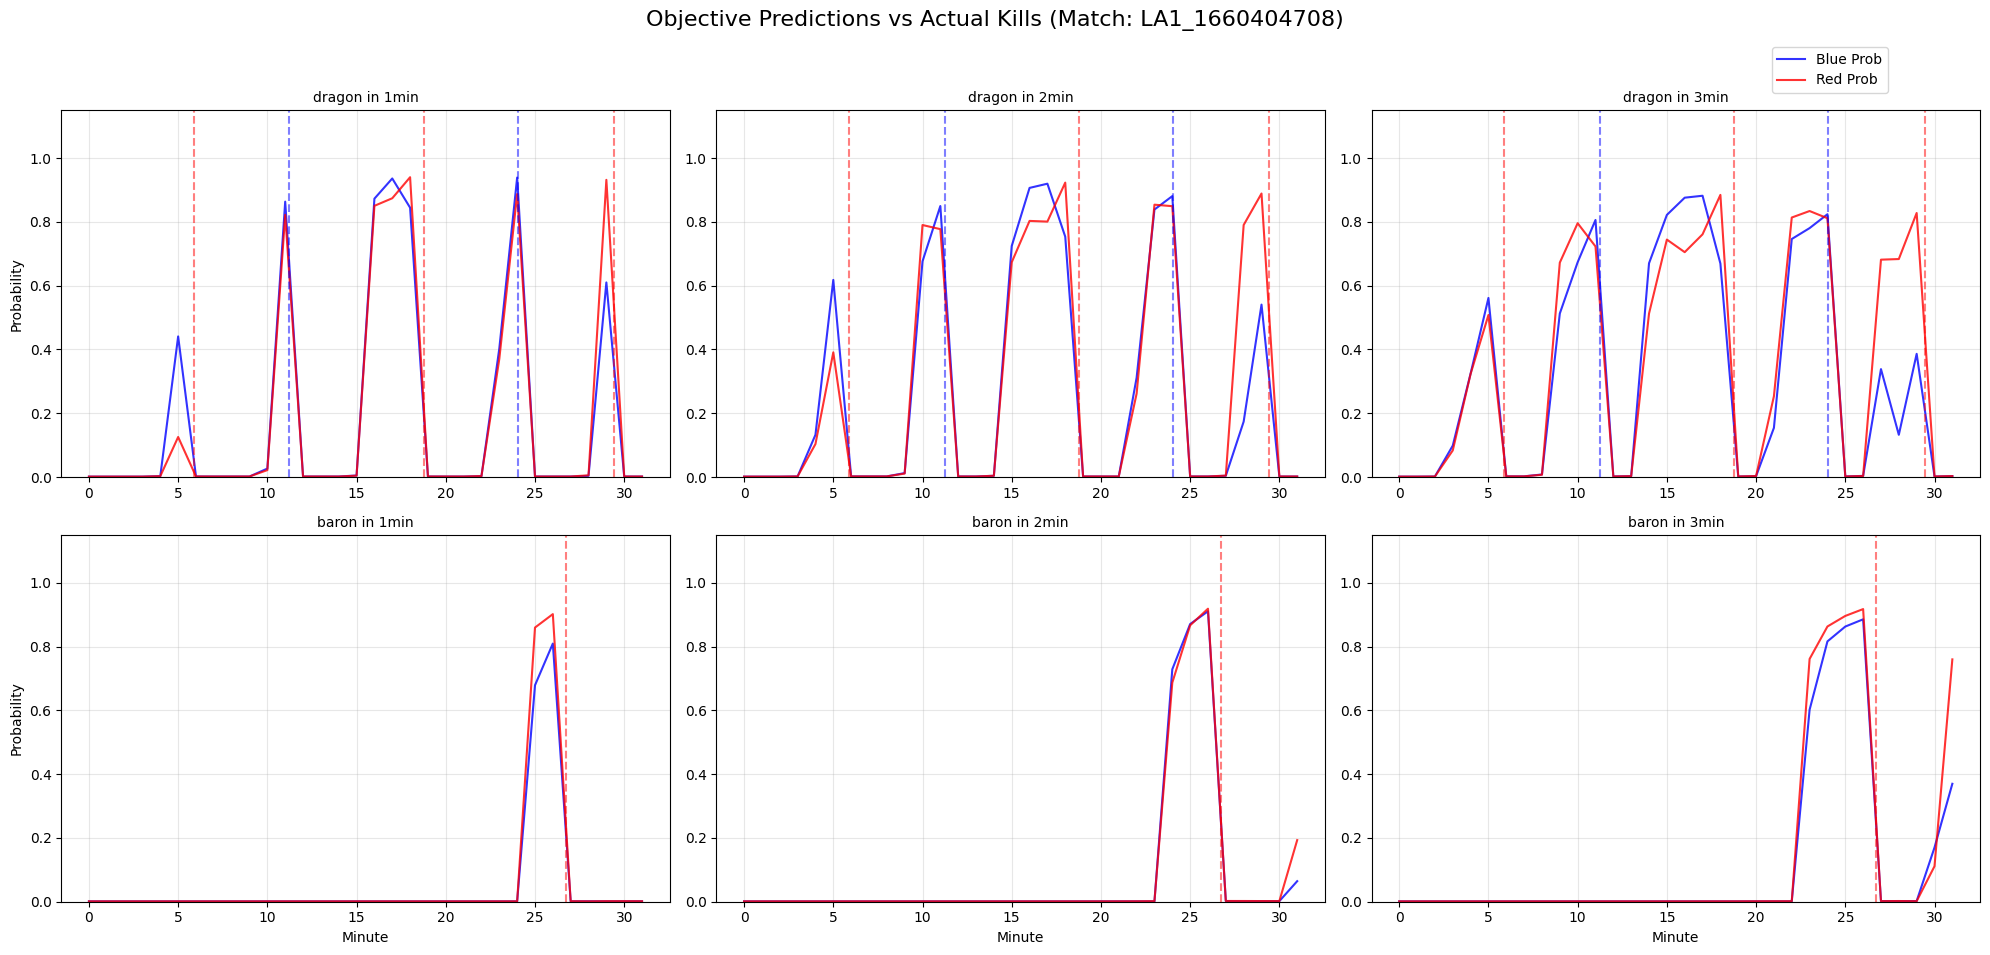

In [8]:
#imports
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

#pick random match to visualize from test data
random_match_id = np.random.choice(test_ids)
print(f"\nvisualizing game: {random_match_id}")

#fetch match data and split into teams
match_data = df_main[df_main['matchId'] == random_match_id].copy()
t100_data = match_data[match_data['teamId'] == 100].sort_values('minute')
t200_data = match_data[match_data['teamId'] == 200].sort_values('minute')

#2x3 grid of all 6 objectives
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle(f'Objective Predictions vs Actual Kills (Match: {random_match_id})', fontsize=16)

#map grid positions to the 6 targets
#1st row dragon, 2nd row baron
grid_map = {
    'dragon_taken_next_1min': (0, 0), 'dragon_taken_next_2min': (0, 1), 'dragon_taken_next_3min': (0, 2),
    'baron_taken_next_1min': (1, 0),  'baron_taken_next_2min': (1, 1),  'baron_taken_next_3min': (1, 2)
}

#create empty model
viz_model = xgb.XGBClassifier()

for target in TARGETS:
    #determine objective types
    objective_name = 'baron' if 'baron' in target else 'dragon'
    
    #load model
    model_filename = f"model_{target}.json"
        
    viz_model.load_model(model_filename)
    
    #predicting
    t100_preds = viz_model.predict_proba(X.loc[t100_data.index])[:, 1]
    t200_preds = viz_model.predict_proba(X.loc[t200_data.index])[:, 1]
    
    #find precise time of actual epic monster kills
    def get_precise_kill_times(team_df, obj):
        kill_col = f'{obj}_kills'
        time_since_col = f'time_since_last_{obj}_sec'
        
        #identify rows where kill count increased compared to previous minute
        diffs = team_df[kill_col].diff().fillna(0)
        kill_rows = team_df.loc[diffs > 0]
        
        timestamps = []
        for _, row in kill_rows.iterrows():
            #get current game time in seconds
            current_sec = row['minute'] * 60
            
            #using time_since_last_X_sec to backtrack to the exact kill moment
            if time_since_col in row:
                time_since = row[time_since_col]
                #kill Time = current time - time since kill
                exact_min = (current_sec - time_since) / 60.0
                timestamps.append(exact_min)
                
        return timestamps

    t100_kills = get_precise_kill_times(t100_data, objective_name)
    t200_kills = get_precise_kill_times(t200_data, objective_name)
    
    #plotting
    ax = axes[grid_map[target]]
    
    #probability lines
    ax.plot(t100_data['minute'], t100_preds, color='blue', alpha=0.8, linewidth=1.5, label='Blue Prob')
    ax.plot(t200_data['minute'], t200_preds, color='red', alpha=0.8, linewidth=1.5, label='Red Prob')
    
    #vertical objective kill lines
    for k in t100_kills:
        ax.axvline(x=k, color='blue', linestyle='--', alpha=0.5)

    for k in t200_kills:
        ax.axvline(x=k, color='red', linestyle='--', alpha=0.5)
            
    #subplot
    ax.set_title(target.replace('_taken_next_', ' in '), fontsize=10)
    ax.set_ylim(0, 1.15)
    ax.grid(True, alpha=0.3)
    
    #only show x-label on bottom row
    if 'baron' in target:
        ax.set_xlabel('Minute')
    
    #only show y-label on left most plots
    if '1min' in target:
        ax.set_ylabel('Probability')

#legend
lines, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()